In [ ]:
# TODO: Create representative sampling -> proportional to each month
# TODO: Visualize weekly each 


# Project 1

## Exploratory data analysis and preprocessing

The **exploratory data analysis** is the statistical treatment to which the samples collected during a research process in any scientific field are subjected.
For greater speed and accuracy, the entire process is usually carried out by computer, with specific applications for statistical treatment.

### Application to Data Mining

In **data mining**, although not mandatory, it is a good practice to analyze the data you will be working with in order to observe its main characteristics in order to get an idea of the structure of the data set, and identify the target variable and possible modeling techniques.

**Basic Process**
- *Transform the data*: It helps us know what to do with null, missing values, or atypical data. In addition, it establishes if there is a need to reduce the dimensionality of data.
- *Visualize*: Use some tool to make a graphical representation of the data, for example, R, Jupyter notebook, Google Colab, etc.
- *Analyze and interpret*: Analyze and interpret the data through different visualizations.
- *Document*: Document all the graphs and statistics generated.

This process is also helpful when reviewing the data description to understand the meaning of each characteristic.

There are several activities in doing an exploratory data analysis but in terms of data mining the key points to be made are:

- Description of the data structure.
- Identification of missing data.
- Detection of outliers.
- Identification of relationships between variable pairs.

The **goal of this project** is to learn how to do data exploration. In this case, data from **New York City Yellow Taxis** is used.

At the end of the notebook, you should be able to answer the following question:


## How has covid affected the use of taxis in New York?

Some of the questions you will ask yourselves throughout the notebook are:
- How has covid changed the use of taxis in NYC?
- What pick-up distribution do the taxis follow and what distance / duration do they take?
- What are the areas where taxis are picked up the least? And where else do people go?
- What are the most usual times?
- Which days of the week and month are used the most? Possible reasons?

**Install and import the required libraries**

In [1]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes
! pip install pandas matplotlib seaborn tqdm

You should consider upgrading via the 'c:\users\msi\documents\trasladar\yo\software engineering\data science & machine learning\0. course\project 1\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\msi\documents\trasladar\yo\software engineering\data science & machine learning\0. course\project 1\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\msi\documents\trasladar\yo\software engineering\data science & machine learning\0. course\project 1\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\msi\documents\trasladar\yo\software engineering\data science & machine learning\0. course\project 1\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\msi\documents\trasladar\yo\software engineering\data science & machine learning\0. course\project 1\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [2]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Global variables

YEARS = [2019, 2020, 2021]

First of all, you need to download the data:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [4]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')
            

  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Data cleaning

In order to have clean and useful data, it is necessary to delete all those rows that contain corrupt information:
- The pick-up is after the drop-off.
- Dates are imported by months and years. Are the dates correct?
- Traveling with zero passengers?
- Do you travel very long or particularly short?
- Negative payments.

**Data Dictionary**

Only the next columns are needed:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Remarks:**

- To speed up the calculations and reduce the computation time, do a uniform sampling of the data (a sample out of 1000).
- Datetime columns are *to_datetime* series (help to search functions)

In [5]:
def load_table(year: str, month: str):
    """
    Function that reads the downloaded data and converts it to a DataFrame
    """
    
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [6]:
year = '2019'
month = '01'

df = load_table(year, month)

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


We will develop **OOP** classes to make the cleaning of the data, so we can **encapsulate** the funtionalities, and in the case we wanted, would be very easy for us to keep track of how the data is changing in each step.

In each object, we have the one or more **atomical functions** (*static methods*). For those, there are simple **tests** to make sure that they are working fine.

In [8]:
from typing import List

class BoundaryFilters():
    def __init__(self, df):
        self.df = df
    
    @staticmethod
    def remove_nan(
        self,
        column
    ):
        """
        Remove the NaN values that we have
        """
        
        self.df = self.df[np.logical_not(np.isnan(self.df[column]))]
        
        return self.df
    
    @staticmethod
    def set_lower_bound_field(
        self,
        column: str, 
        value: float = 0.0,
        convert_int: bool = False
    ):
        
        """
        Filter the values which are lower than a certain value for a given column.
        
        Params:
        - self
        - column: the column for which we want to filter the values
        - value: the value that we  want to set lower bound
        - convert_int: whether we want to convert the variable into an integer
        
        Returns:
        - df: dataframe the field lower bounded
        
        """
        
        # First we remove the NaNs, we we would not be able to make this filter
        self.remove_nan(self, column)

        if convert_int:
            self.df[column] = self.df[column].astype(int)
        self.df = self.df[self.df[column] > value]
        
        # We make the text
        assert min(self.df[column]) > value

        return self.df

    @staticmethod
    def set_upper_bound_field(
        self,
        column: str,
        value: float,
        convert_int: bool = False
    ):
        
        """
        Filter the values which are higher than a certain value for a given column.
        
        Params:
        - self
        - column: the column for which we want to filter the values
        - value: the value that we  want to set higher bound
        - convert_int: whether we want to convert the variable into an integer
        
        Returns:
        - df: dataframe the field higher bounded
        
        """
        
        # First we remove the NaNs, we we would not be able to make this filter
        self.remove_nan(self, column)
        
        if convert_int:
            self.df[column] = self.df[column].astype(int)
        self.df = self.df[self.df[column] < value]
        
        # We make the text
        assert max(self.df[column]) <= value

        return self.df

    def filter_lower_bound(self):
        
        """
        Apply to a group of fields a lower bound.
        
        Params:
        - self
        
        Returns:
        - df: dataframe with a lower bound applied to a filter
        
    
        """

        self.set_lower_bound_field(self, 'passenger_count', True)
        self.set_lower_bound_field(self, 'total_amount')
        self.set_lower_bound_field(self, 'fare_amount')
        self.set_lower_bound_field(self, 'trip_distance')

        return self.df

    def filter_upper_bound(self):
        
        """
        Apply to a group of fields a higher bound.
        
        Params:
        - self
        
        Returns:
        - df: dataframe with a higher bound applied to a filter
        
    
        """

        self.set_upper_bound_field(self, 'trip_distance', 6700)
        self.set_upper_bound_field(self, 'payment_type', 7)

        return self.df

    def filter_positive_diff(
        self,
        fields: List[str] = ['tpep_dropoff_datetime', 'tpep_pickup_datetime'],
        is_date: bool = True
    ):
        
        """
        Function to filter for the voyages that had a duration which is > 0.
        
        Params:
        - self
        - fields: the fields for which we will make a comparison and filter them by positivity
        
        Returns:
        - df: dataframe with only voyages that had a duration > 0
        
        """
        
        self.df['diff'] = self.df[fields[0]] - self.df[fields[1]]
        
        if is_date:
            self.df['diff'] = self.df['diff'].dt.total_seconds()

        # Filter by positive voyages
        self.set_lower_bound_field(self, 'diff')
        
        return self.df
    
    def apply_filters(self):
        
        """
        Function to apply a group of filters into the dataframe.
        
        Params:
        - self
        
        Returns:
        - df: dataframe with the filters applied to it.
        
        """
        
        self.filter_lower_bound()
        self.filter_upper_bound()
        self.filter_positive_diff()
        
        return self.df

In [9]:
class CheckField():
    def __init__(self, df, year, month):
        self.df = df
        self.year = str(year).strip()
        self.month = str(month).strip()
    
    @staticmethod
    def correct_field(
        self,
        field_name: str,
        field_value: float,
    ):
        
        """
        Function to check that a certain field has consistent values with its context (correct year, month, ...)
        
        Params:
        - self
        - field_name: the field for which we want to check for consistent values
        - field_value: the value for which the field is consistent with its context
        
        Returns:
        - df: dataframe with the field consistent to its value
        
        """
        
        if field_name not in ['year', 'month']:
            raise Exception('Field Name must be: [year, month]')
            
        self.df[field_name] = self.df[field_name].apply(lambda x: str(x))
        self.df = self.df[self.df[field_name] == field_value]
        
        # And we need to make sure that this field now only has our value wanted
        assert self.df[field_name].unique() == field_value

        return self.df
        
    def apply_correctness_field(
        self,
        field: str,
        only_year: bool = False
    ):        
        
        """
        Function to apply correctness about the year and month values on a certain field.
        
        Params:
        - self
        - field: the field for which we want to apply correcntess on the month & year
        - only_year: if we want to apply correctness of only year
        
        Returns:
        - df: dataframe with the field consistent to the year & month context
        
        """
        
        # Add the data needed
        self.df['year'] = self.df[field].dt.year
        self.df['month'] = self.df[field].dt.month
        
        # Simplify the data: both pickup and dropoff on the same month, year & day
        self.correct_field(self, 'year', self.year)
        
        if not only_year:
            self.correct_field(self, 'month', self.month)
        
        return self.df

    def apply_correctness(
        self
    ):
        
        """
        Apply correcntess of the month & year on a group of fields.
        
        Params:
        - self
        
        Returns:
        - df: dataframe with the fields consistent to the year & month context
        
        """
        
        # Apply the correctness
        self.apply_correctness_field('tpep_pickup_datetime')
        self.apply_correctness_field('tpep_dropoff_datetime')
        
        return self.df

In [10]:
from typing import List

class CleanData(BoundaryFilters, CheckField):
    def __init__(
        self, 
        df: pd.DataFrame, 
        year: str, 
        month: str
    ):
        
        """
        Initialization of the Clean Data object, which have two main functionalities: Limit Boundaries & Check Fields
        
        Params:
        - self
        - df: dataframe that we want to clean
        - year: the year in which the dataframe has data
        - month: the month in which the dataframe has data
        
        """
        
        self.df = df
        self.year = str(year).strip()
        self.month = str(month).strip()
    
    @staticmethod
    def pre_process(
        self,
        columns: List[str],
        columns_filter: bool = True,
        rows_filter: bool = True,
    ):
        
        """
        
        Pre Process the dataframe, which means:
        - Only consider the columns we want
        - Dropping duplicate rows
        
        Params:
        - self
        - columns: the columns we want to consider only in the df
        - columns_filter: if we want to apply the filter on the columns
        - rows_filter: if we want to apply the filter on the rows
        
        Returns:
        - df: dataframe with the filters applied to it.
        
        """
        
        # Filtering the columns we have in the df
        if columns_filter:
            self.df = self.df[columns]
            
        # Filtering the rows we have in the df
        if rows_filter:
            self.df.drop_duplicates(inplace=True, keep='first', ignore_index=True)
        
        return self.df
    
    @staticmethod
    def sample(
        self,
        n
    ):
        
        """
        Function to create a sample on the dataframe.
        
        Params:
        - self
        - n: the amount we want to reduce the initial dataframe
        
        Returns:
        - df: the dataframe which is only a sample of the initial one
        
        """
        
        previous_length = len(self.df)
        
        # Create the dataframe to be a fraction of the inital one
        frac = 1/n
        self.df = self.df.sample(frac=frac)
        
        # We have to make sure that the size is correct (with a certain error)
        # TODO: Create a function to apply this assertion
        # assert len(self.df) * n - previous_length < previous_length / n ** 1.4
        print(len(self.df), previous_length)
        
        return self.df
    
    def clean_data(
        self, 
        columns: List[str],
        n: int = 1000
    ):
        
        """
        Function to apply the cleaning of the data on a dataframe.
        
        Params:
        - self
        - columns: list of columns that we want only to consider in the analysis
        - n: the amount by which we want to reduce the initial dataframe
        
        Returns:
        - df: dataframe with the data in it cleaned
        
        """
        
        # Sample first to speed up the process (not recommended, but just for learning pursposes)
        self.sample(self, n)

        self.pre_process(self, columns)
        self.apply_filters()
        self.apply_correctness()
        
        self.df.reset_index(inplace=True, drop=True)
        
        return self.df

In [11]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data, year, month, sampling = 1000):
    """
    Function that clears the month data.
    """
    
    # Using Objects we can encapsulate the functionalities we want (and we could keep track of each state of the process)
    clean_data_instance = CleanData(data, year, month)
    
    clean_data_df = clean_data_instance.clean_data(
        columns=required_data,
        n=sampling
    )
    
    return clean_data_df

In the ***post_processing*** function you can add all information you need in order to perform the necessary exploration.

In [416]:
from typing import Dict, List

class PostProcessing():
    def __init__(self, df):
        self.df = df

    @staticmethod
    def set_outliers_column(
        self,
        low: float,
        high: float,
        column: str,
        output_column_name: str
    ):
        """
        We are going to build a new column with the information about the outlier.
        
        Params:
        - low: which is the value of the lower outlier
        - high: which is the value of the high outlier
        - column: for which column do we want to set the outlier
        - output_column_name: which is the name of the column with the information whether is an outlier
        """
        
        for idx, row in self.df.iterrows():
            if row[column] < low:
                self.df.at[idx, output_column_name] = -1
            
            if row[column] > high:
                self.df.at[idx, output_column_name] = 1
            
            else:
                self.df.at[idx, output_column_name] = 0
        
        # By default would put a float type, we can change it to int
        self.df = self.df.astype({output_column_name: int})
        
        return self.df
    
    def detect_outliers_field(
        self,
        field: str,
        output_column_name: str,
        lower: float = 0.01,
        higher: float = 0.99,
        is_time: bool = False,
    ):
        """
        Function to detect the high and lower quantiles.
        
        Params:
        - field: for which field do we compute quantiles
        - output_column_name: which is the name of the column with the information whether is an outlier
        - lower: which lower quantile is going to be the boundary for lower outliers
        - higher: which higher quantile is going to be the boundary for higher outliers
        - is_time: whether the column is a time or not
        """
        
        low, high = self.df[field].quantile([lower, higher])
        
         # We set the percentiles in a new oclumn
        self.set_outliers_column(
            self,
            low,
            high,
            column=field,
            output_column_name=output_column_name,
        )
                
        # Clean the changes we have made

        return self.df
    
    
    def detect_outliers_diff_fields(
        self,
        fields: List[str] = ['tpep_dropoff_datetime', 'tpep_pickup_datetime'],
        output_column_name: str = 'voyage_time_outliers',
        lower: float = 0.01,
        higher: float = 0.99,
        is_time: bool = False,
        keep_column: bool = False
    ):
        
        """
        
        Detect which are the percentiles in a difference between two fields, and filter them.
        
        Params:
        - fields: which are the fields that we want to make the difference
        - output_column: the column that results of the detection of the percentile
        - lower: the lower percentile we want to detect
        - higher: the higher percentile we want to detect
        - is_time: if the fields are dates or datetimes
        - keep_column: if we want to keep the column of diff
        
        """

        self.df['diff'] = self.df[fields[0]] - self.df[fields[1]]
        
        if is_time:
            self.df['diff'] = self.df['diff'].dt.total_seconds()

        low, high = self.df['diff'].quantile([lower, higher])
        
        # We set the percentiles in a new oclumn
        self.set_outliers_column(
            self,
            low,
            high,
            column='diff',
            output_column_name=output_column_name,
        )
                
        # Clean the changes we have made
        if not keep_column:
            self.df.drop(['diff'], axis=1, inplace=True)

        return self.df
    
    def apply_detection_outliers(
        self,
        field_outliers: Dict[str, str]
    ):
        
        self.detect_outliers_diff_fields(keep_column=True)
        
        # For the optional fields we want to compute
        for key, value in field_outliers.items():
            self.detect_outliers_field(key, value)
        
        return self.df
        
    
    def get_periodical_data(
        self,
        column: str,
        prefix: str
    ):
        
        self.df[prefix + '_hour'] = self.df[column].dt.hour
        self.df[prefix + '_day'] = self.df[column].dt.day
        self.df[prefix + '_week'] = self.df[column].dt.week
        self.df[prefix + '_month'] = self.df[column].dt.month
        self.df[prefix + '_year'] = self.df[column].dt.year

In [20]:
def post_processing(data):
    """
    Function to implement any type of post-processing required.
    """
    
    post_processing_instance = PostProcessing(data)
    
    # Get the periodical data needed
    post_processing_instance.get_periodical_data('tpep_pickup_datetime', 'pickup')
    post_processing_instance.get_periodical_data('tpep_dropoff_datetime', 'dropoff')

    # Handle outlier information
    field_outliers = {
        'trip_distance': 'trip_distance_outlier',
        'total_amount': 'total_amount_outlier',
        'fare_amount': 'fare_amount_outlier'
    }
    
    df = post_processing_instance.apply_detection_outliers(field_outliers)
    df.reset_index(inplace=True, drop=True)
    
    return df

Create a new dataset that contains all the information for the years: 2019, 2020, and 2021.

Remember that in order to reduce the memory required, you can take a subsample of the data.

In [15]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

7697 7696617
7049 7049370
7867 7866620
7476 7475949
7598 7598445
6972 6971560
6310 6310419
6073 6073357
6568 6567788
7214 7213891
6878 6878111
6896 6896317


  0%|          | 0/12 [00:00<?, ?it/s]

6405 6405008
6299 6299367
3008 3007687
238 238073
348 348415
550 549797
800 800412
1007 1007286
1341 1341017
1681 1681132
1509 1509000
1462 1461898


  0%|          | 0/12 [00:00<?, ?it/s]

1370 1369769
1372 1371709
1925 1925152
2171 2171187
2507 2507109
2834 2834264
2822 2821746
2789 2788757
2964 2963793
3464 3463504
3473 3472949
3214 3214369


In [16]:
df = post_processing(df)
df.shape

(36438, 22)

In [17]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,diff,...,pickup_days,pickup_month,pickup_year,dropoff_days,dropoff_month,dropoff_year,voyage_time_outliers,trip_distance_outlier,total_amount_outlier,fare_amount_outlier
0,2019-01-28 11:47:20,2019-01-28 12:00:21,4.0,1.96,90,50,1,10.5,13.56,0 days 00:13:01,...,28,1,2019,28,1,2019,0,0,0,0
1,2019-01-13 07:39:58,2019-01-13 07:47:58,6.0,2.19,162,68,1,9.0,11.76,0 days 00:08:00,...,13,1,2019,13,1,2019,0,0,0,0
2,2019-01-18 10:25:38,2019-01-18 10:29:18,5.0,0.49,238,239,2,4.5,5.30,0 days 00:03:40,...,18,1,2019,18,1,2019,0,0,0,0
3,2019-01-26 03:25:59,2019-01-26 03:34:40,2.0,1.50,68,211,3,8.0,9.30,0 days 00:08:41,...,26,1,2019,26,1,2019,0,0,0,0
4,2019-01-23 07:33:49,2019-01-23 07:49:39,5.0,1.84,140,236,1,11.5,13.86,0 days 00:15:50,...,23,1,2019,23,1,2019,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,2021-12-12 14:21:07,2021-12-12 15:32:01,4.0,19.56,233,1,1,84.0,98.05,0 days 01:10:54,...,12,12,2021,12,12,2021,1,1,1,1
781,2021-12-14 17:10:42,2021-12-14 17:19:56,2.0,1.35,234,79,1,7.5,14.80,0 days 00:09:14,...,14,12,2021,14,12,2021,0,0,0,0
782,2021-12-29 13:04:22,2021-12-29 13:11:16,2.0,1.06,43,230,1,6.5,12.25,0 days 00:06:54,...,29,12,2021,29,12,2021,0,0,0,0
783,2021-12-08 14:55:40,2021-12-08 15:13:57,2.0,1.50,237,236,1,12.0,19.12,0 days 00:18:17,...,8,12,2021,8,12,2021,0,0,0,0


## 02. Visualizations (by years)

### Number of trips by year

Can you answer the question: **Has covid increased / decreased the number of trips made by taxis?**

To answer this question, create a bar figure showing the number of trips per year.

In [27]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    A function that creates a bar figure from the dataframe *df* and the content of the *column* that contains the information.
    """
    
    sns.countplot(x = column, data = df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()
    

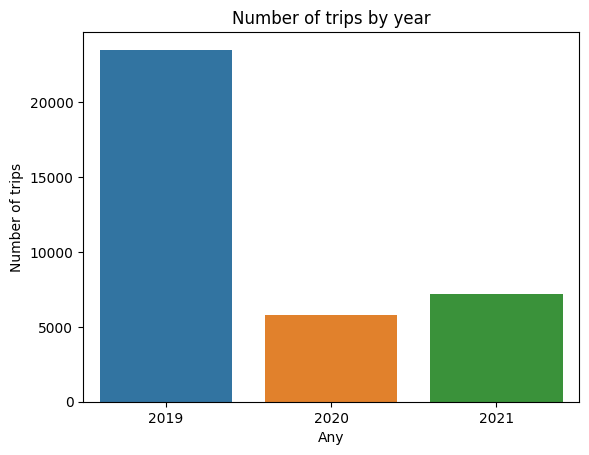

In [28]:
bar_plot(df, 'year', 'Any', 'Number of trips', 'Number of trips by year')

**Question: Is this the behavior you expected? Why?**

> ANSWER

This is what we would expect, as in the year of **2019** there was no Covid.
Then, the first case of Covid-19 in NY started on **March 2020**. And then it increased exponentially the pandemic, so this is why in 2020 there is the lowest amount of trips.
Finally, in **2021** the NY economy started to recuperate the normal course of action, that is why there is a bit of increase compared to the before year.

Now, you will visualize **how many passengers there are per taxi and per year**.

Create a figure with three subplots (one per year) where can be seen the number of passengers per year.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [269]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Function that displays how many passengers there are per taxi and per year
    """
    
    # Which is the stat that we represent
    which_stat = 'proportion' if norm else 'count'
    
    g = sns.FacetGrid(df, col="year", height=5.5, aspect=.65)
    g.map(
        sns.histplot, 
        "passenger_count",
        stat=which_stat,
        discrete=True,
        bins=10,
    )
    
    
    # Now we set the axes labels
    g.set_xlabels(xlabel)    
    g.set_ylabels(ylabel)
    
    # Now we set the title
    g.fig.subplots_adjust(top=0.8) 
    g.fig.suptitle(title)
    
    plt.ylim(ylim)
    plt.show()

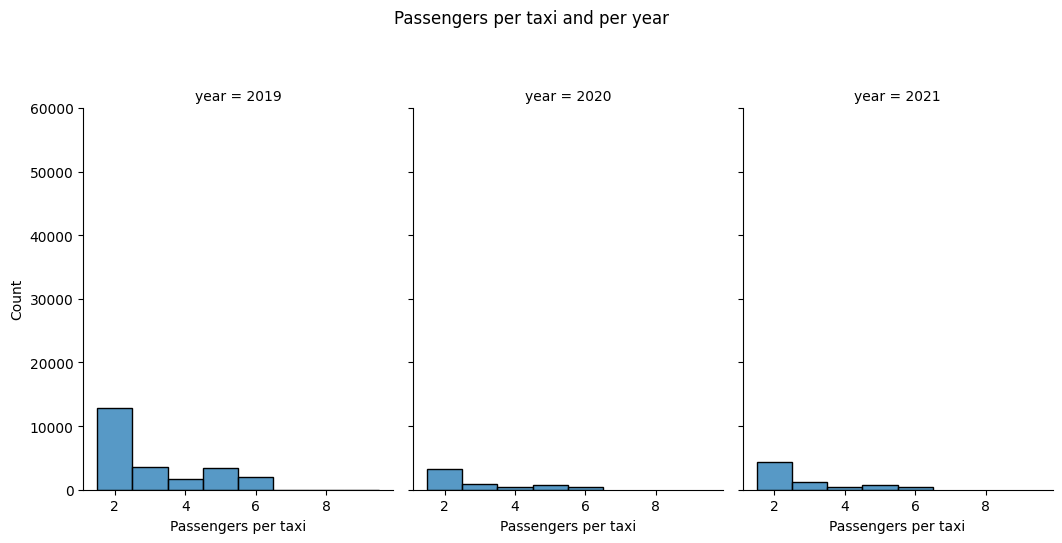

In [270]:
passengers_taxi_year(df, (0, 60000), 'Passengers per taxi', 'Count', 'Passengers per taxi and per year')

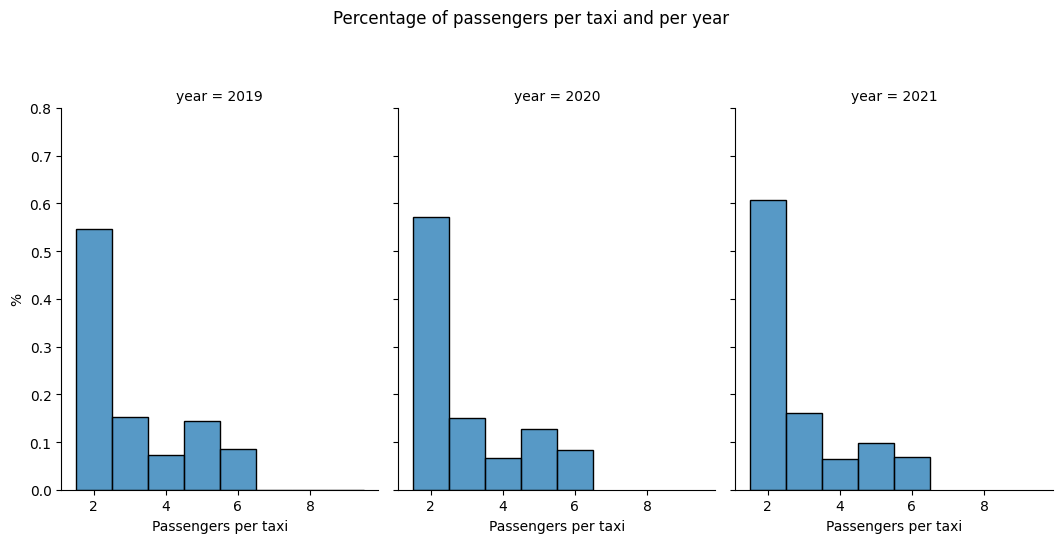

In [271]:
passengers_taxi_year(df, (0, 0.8), 'Passengers per taxi', '%', 'Percentage of passengers per taxi and per year', norm = True)

In the previous figure, you have visualized each year separately. To make the visualization easier to interpret, combine all the information into a graph.

The expected visualization has to contain three columns (different colors) for each number of passengers.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [331]:
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Function that displays how many passengers there are per taxi
    """
    
    # Set which is going to be the metric
    which_stat = 'proportion' if norm else 'count'
    
    # Convert the passenger count to a category, so can be plotted as such
    df_plot = df.loc[:, ['passenger_count', 'year']]
    df_plot['passenger_count'] = df_plot['passenger_count'].astype('category')
    
    # Create the histogram
    sns.histplot(
        x=df_plot['passenger_count'], 
        hue=df_plot['year'], 
        multiple="dodge", 
        stat = which_stat, 
        binwidth=0.6,
        shrink=0.8
    )
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

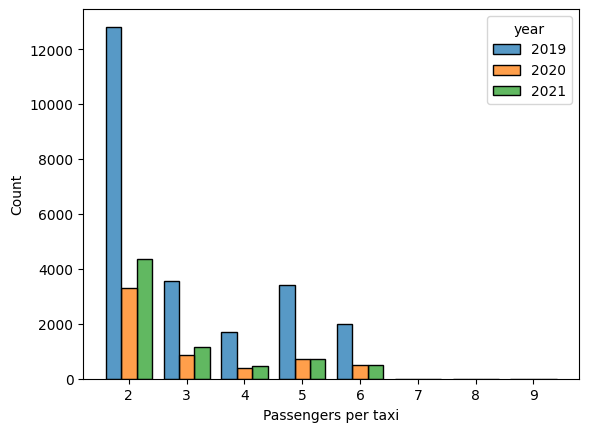

In [332]:
passengers_taxi(df, 'Passengers per taxi', 'Count')

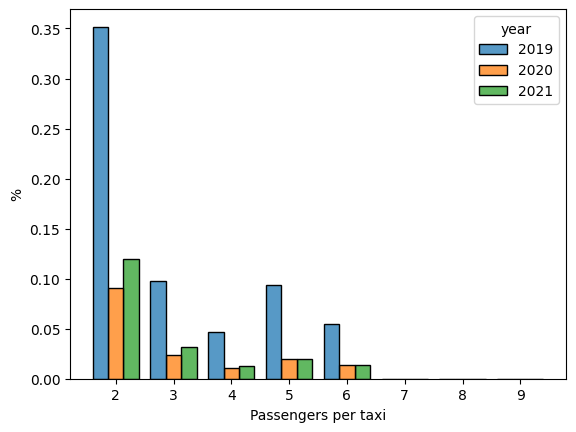

In [333]:
passengers_taxi(df, 'Passengers per taxi', '%', norm = True)

**Question: What impact have you seen on the data? Do you think covid had a lot of impact?**

> ANSWER

We can see that the count of the passengers, the lowest one is in year of 2020.

But when considering the distribution of the proportion on the number of passengers for each year, we can see that this proportion holds the same through the years.

So i think that Covid had a lot of impact in **absolute** terms of how many people where using the taxis, but did not change the relative number of passengers usage of them.

## 03. Number of trips

So far, you have seen the number of trips there have been in the years studied.

Let's study what changes can be seen if you aggregate the data by hours, days of the week, week of the year, and months.


These visualizations have to be done for the *pick-up* and *drop-off* columns. 

Furthermore, the information has to be split by year and represented with dashed lines, and marked with a round or cross wherever the value is.

In [417]:
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.day

In [418]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Function that visualizes the number of trips by different data aggregations
    """
    
    fig, axs = plt.subplots(1, 2)
    
    fig.set_figheight(4)
    fig.set_figwidth(11)
    
    for i in range(2):
        for year in YEARS:
            months, counts = np.unique(
                df.loc[df.year == str(year), columns[0]],
                return_counts=True
            )

            axs[i].scatter(
                months, 
                counts
            )

            axs[i].plot(
                months, 
                counts, 
                label=year,
                alpha=0.2,
                linestyle='dashed'
            )
            
            axs[i].set_xlabel(xlabel + ': ' + columns[i])
            axs[i].set_ylabel(ylabel)
        
    plt.legend()
    fig.suptitle(title)
    plt.show()

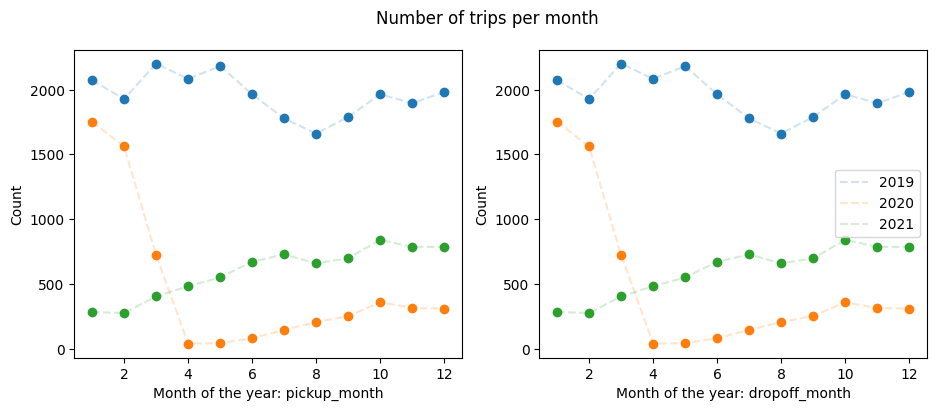

In [419]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Number of trips per month', xlabel = 'Month of the year', ylabel = 'Count')

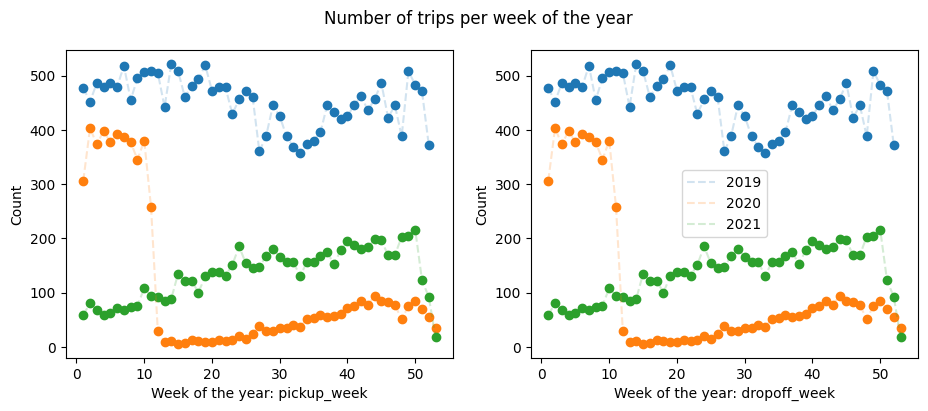

In [420]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Number of trips per week of the year', xlabel = 'Week of the year', ylabel = 'Count')

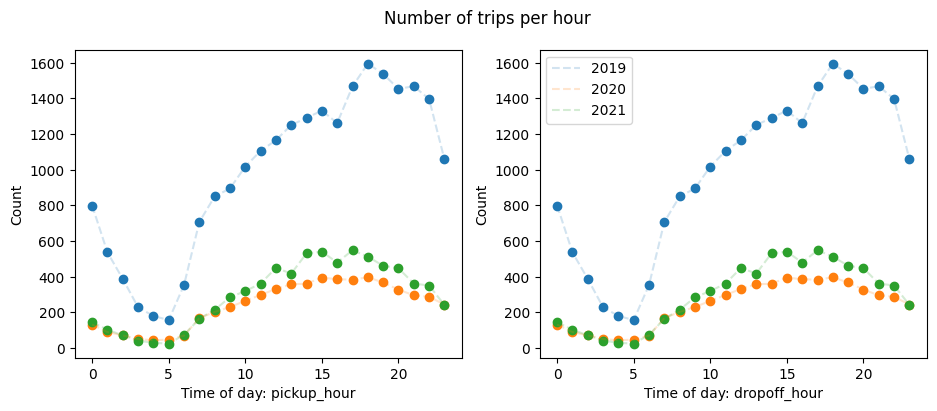

In [421]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Number of trips per hour', xlabel = 'Time of day', ylabel = 'Count')

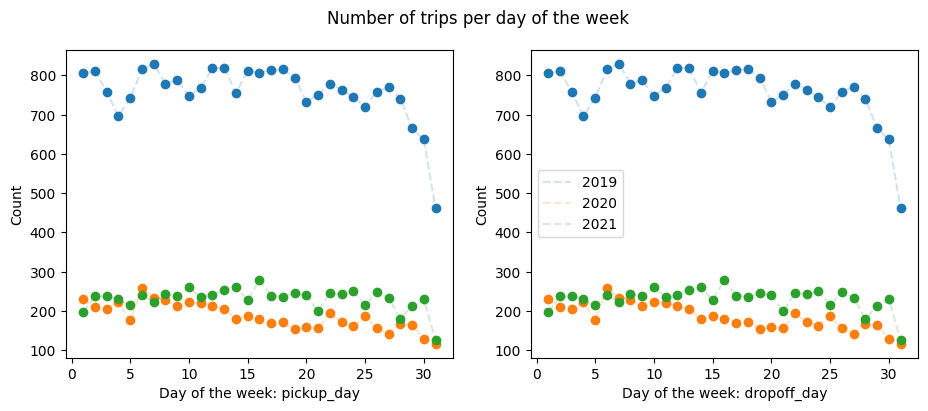

In [422]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Number of trips per day of the week', xlabel = 'Day of the week', ylabel = 'Count')

**Question: What behaviors do you see in each case? What do you think is the reason?**

> ANSWER

## 04. Distance/duration and speed relationship

In the data, there is the distance traveled by taxis on each trip. Furthermore, you can extract the duration of the trips using: *tpep_dropoff_datetime* and *tpep_pickup_datetime*.

Now, you will find out how covid affected the distances and durations of journeys along with the speed of taxis.

Do you think the traffic density changed?

### Histograms

Visualize the **histograms** of distance and duration per year.

You can use *plt.hist()* or *plt.bar()* function.

In [ ]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Function that creates a histogram from the information contained in the column *column* of the dataframe *df*
    """
    
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
visualize_histograms(df, 'trip_distance', title = 'Distance traveled per year', 
                     xlabel = 'Distance (km)', ylabel = 'Count', xlim = (-5, 80))

visualize_histograms(df, 'trip_duration', title = 'Duration of trips per year', 
                     xlabel = 'Duration (h)', ylabel = 'Count', xlim = (-1, 25) )

**QUESTIONS:**

* How do you think covid affected travel distances and durations?

* And the speed of taxis?

> ANSWER

### Scatter plot and correlation

Create scatter plots to illustrate the relationship between trip duration and distance.

It is possible that the data contain samples outside the distribution (outliers). In this case, skip this samples and display the figure again.

To see if any correlation exists, it is interesting to use the *sns.regplot()* function.

In [ ]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Function that displays a scatter plot given the name of the columns that contains the information
    """
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (h)')

In [ ]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (h)', True)

**Question: Can you see any relationship? Can you calculate the correlation between the data to get more information?**

> ANSWER

As you did in section 3, visualize the time and distance data for the weeks and months of the year.

In [ ]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Function that show the distance / duration of trips in the time determined
    """
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Week of the year', ylabel = 'Mean distance (km)', title = 'Distance by weeks of the year')

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean distance (km)', title = 'Distance by months of the year')

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Week of the year', ylabel = 'Mean duration (h)', title = 'Duration by weeks of the year')

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean duration (h)', title = 'Duration by months of the year')

**Question: Is there any strange behavior apart from covid? What can it be caused by?**

> ANSWER

So far, you have shown the data by aggregating different information.

Now, you have to visualize the data like images. For that, you will use the *plt.imshow()* function which displays images and arrays.

Implement a function that displays heatmaps by year (each function display 3 heatmaps, one per year):

- a heatmap showing what time of day are the longest trips during the year.
- a heatmap showing what time of day are the longest trips during the week.

In [ ]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a heatmap
    """
    
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Days of the year', 'Hours of the day')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Times of day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeat the previous heatmaps visualizing the distance.

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Days of the year', 'Times of the day')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Finally, view the average speed at different times of the day during the week.

In [ ]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a speed heatmap
    """
    
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Question: Which conclusions do you obtain from the heatmaps?**
    
> ANSWER

## 05. Visualize the locations of the trips

In [ ]:
df.head()

The data only has the ID of a location, so you need to add the latitude and longitude.

This information is saved in *data/geodata/taxi_zones.shp*.

The next cells can be understood as a black box.

In [ ]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [ ]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [ ]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Now you have two dataframes that you need to join. Use the *pd.merge* function to add the longitude and latitude to the *df* dataframe:

In [ ]:
# HERE YOUR CODE
merge = ...

In [ ]:
merge.shape

## 06. Which are the areas/zones with more pick-up and drop-off?

In this section, you have to visualize the areas where taxis are most used.

The first step is to sort and save in a variable the most common places in the pick-up and drop-off.

The variables *top_pu* and *top_do* contains a dataframe with columns: 'year', 'PULocationID', and 'count'.

In [ ]:
# Pick-up
# HERE YOUR CODE
top_pu = ...
top_pu.columns = ['year', 'PULocationID', 'count']

# Drop-off
# HERE YOUR CODE
top_do = ...
top_do.columns = ['year', 'DOLocationID', 'count']

Print the 5 most frequent zones per year and in each case (pick-up and drop-off).

In [ ]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    
    """
    Function that print the most common zones by year
    """
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
show_top_n(top_pu, 'PULocationID', df_loc)

In [ ]:
show_top_n(top_do, 'DOLocationID', df_loc)

**Let's see with a heat map which are the most common zones**

In [ ]:
for year in YEARS:
    
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'count']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Question: Why do you think the Manhattan area has more trips?**

> ANSWER

## 07. Hospitals

How has the travel destination changed? Are more people going to hospitals?

In the next cell, there is a DataFrame with the most important hospitals in New York and their locations.

In [ ]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

Use the latitude and longitude of each hospital and the latitude and longitude of the zone (information in *merge* dataframe) to see the distribution of the hospitals "on the map".

To do this, use a scatter plot. It will be better understood if the points are transparent (parameter *alpha*).

Also, remember how the longitude and latitude data have to be plotted in the figure.

Then repeat the same scatter plot but separated by years.

In [ ]:
def scatter_locations(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations"""
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
scatter_locations(merge, hospitals)

In [ ]:
def scatter_locations_per_year(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations per year"""
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
scatter_locations_per_year(merge, hospitals)

**Question: Do you see any behavior?**

>ANSWER

To find out how trips to hospitals have changed, you need to detect in which zone is each hospital.

To do it, you need to calculate the distances between the hospitals and the zones. 

Do not calculate the distance point-to-point, but matrix-wise.

In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

# HERE YOUR CODE
dist = ...

In [ ]:
# Distances as an image
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Find a way to locate the nearest sector based on distances.

In [ ]:
# HERE YOUR CODE
hospitals_locations = ...
hospitals['LocationID'] = hospitals_locations

In [ ]:
hospitals.head()

Now that you know the zone of each hospital, visualize how many trips are related to them.

You will assume that all trips in the zone go to the hospital.

Make a single figure with two bar plots showing the number of trips for each year and the % of total trips.

In [ ]:
def trips_hospitals(df, hospitals_locations):
    """
    Function that displays a single figure with two bar plots showing the number of trips for each year and the % of total trips.
    """
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
trips_hospitals(df, hospitals_locations)

## 08. Curiosity killed the cat

In the **first part** you must view and comment on the examples you have removed, such as very long distances, very short distances...

In the **second part** you are free to choose and make visualizations that bring you extra information that has not been seen before.

## 09. Report

Based on the data exploration you have done throughout this notebook, make a short report summarizing and justifying all the changes that have arisen due to covid.